# Multi-group Agreement (Employment)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the Employment
dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from folktables import ACSDataSource, ACSEmployment

# ACS Employment Dataset (2016, California)
The ACS Employment is a benchmark derived from the 2018 American Community Survey. The task is to predict whether an 
individual is employed, after filtering the survey sample to only include individuals between the ages of 16 and 90.
The full dataset has $n = 3,236,107$ examples, but we use a subsample of the dataset from California in 2016 to get a dataset
of $n = 376,035$ examples total.

## Preprocess and Clean ACS Employment
The ACS Employment dataset (California, 2016) is a binary classification task with $d=16$ features.

We run the following experiments with the following (overlapping) group structure, $\mathcal{G}$. We let $|\mathcal{G}| = 12.$
- **Race.** Note that we dropped race values $4$ and $5$ because they are too small in the dataset (*Alaska Native alone*
and *American Indian and Alaska Native tribes specified*). The possible values for race are:
  - White alone
  - Black or African-American alone
  - American Indian alone
  - Asian alone
  - Native Hawaiian and Other Pacific Islander alone
  - Some Other Race alone
  - Two or More Races
- **Sex.** The possible values for sex are:
  - Male
  - Female
- **Age.** Split between $\mathrm{Age} > 65$ and $\mathrm{Age} \leq 65$. The possible values for age are:
  - 0 - 99 (integers)

In [2]:
data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
sex = features[:, -2]
old = (features[:,0] > 65)
features.shape

(376035, 16)

In [3]:
group_names = []
group_memberships = []
group_memberships.append([True] * label.shape[0])
group_names.append('ALL')
for g in np.unique(group):
    if g == 4 or g == 5: # group is too small
        continue
    group_memberships.append(group == g)
    group_names.append('R{0}'.format(g))
group_memberships.append(sex == 1)
group_names.append('S1')
group_memberships.append(sex == 2)
group_names.append('S2')
group_memberships.append(old == False)
group_names.append('A1')
group_memberships.append(old == True)
group_names.append('A2')
num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 12


In [4]:
to_one_hot = set(['MAR', 'RELP', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'DREM', 'RAC1P'])
to_leave_alone = set(ACSEmployment.features) - to_one_hot
one_hot_inds = [i for i, x in enumerate(ACSEmployment.features) if x in to_one_hot]
leave_alone_inds = [i for i, x in enumerate(ACSEmployment.features) if x in to_leave_alone]

steps = [('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_inds), ('num', MinMaxScaler(), leave_alone_inds)]
col_transf = ColumnTransformer(steps)
features_t = col_transf.fit_transform(features).toarray()
print("Column-transformed X has shape: {}".format(features_t.shape))

Column-transformed X has shape: (376035, 69)


In [5]:
# Train-test split
splits = train_test_split(*tuple([features, label] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

In [6]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

print('Group\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group	train	test
0 (ALL)	300828	75207
1 (R1)	184961	46271
2 (R2)	15047	3784
3 (R3)	2080	517
4 (R6)	45385	11425
5 (R7)	1057	280
6 (R8)	37135	9181
7 (R9)	14416	3562
8 (S1)	148622	36981
9 (S2)	152206	38226
10 (A1)	254184	63388
11 (A2)	46644	11819


In [7]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.44420067280971187
P(Y=1 | group 1) = 0.44883404292105206
P(Y=1 | group 2) = 0.38847780126849896
P(Y=1 | group 3) = 0.3307543520309478
P(Y=1 | group 4) = 0.47728665207877463
P(Y=1 | group 5) = 0.4642857142857143
P(Y=1 | group 6) = 0.44298006753077007
P(Y=1 | group 7) = 0.3571027512633352
P(Y=1 | group 8) = 0.4840593818447311
P(Y=1 | group 9) = 0.4056401402186993
P(Y=1 | group 10) = 0.49899034517574303
P(Y=1 | group 11) = 0.15035112953718588


## Utilities for Training/Evaluation

In [19]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [20]:
# Construct pairs of groups for "agreement" comparison
race_sex_train = {}
race_sex_test = {}
race_age_train = {}
race_age_test = {}
sex_age_train = {}
sex_age_test = {}

# Race-Sex Intersections
for r in range(1, 8):
    race_sex_train[r] = {}
    race_sex_test[r] = {}

    race_sex_train[r][8] = group_train[r] & group_train[8]
    race_sex_train[r][9] = group_train[r] & group_train[9]
    race_sex_test[r][8] = group_test[r] & group_test[8]
    race_sex_test[r][9] = group_test[r] & group_test[9]

# Race-Age Intersections
for r in range(1, 8):
    race_age_train[r] = {}
    race_age_test[r] = {}

    race_age_train[r][10] = group_train[r] & group_train[10]
    race_age_train[r][11] = group_train[r] & group_train[11]
    race_age_test[r][10] = group_test[r] & group_test[10]
    race_age_test[r][11] = group_test[r] & group_test[11]

# Sex-Age Intersections
sex_age_train[8] = {}
sex_age_train[9] = {}
sex_age_train[8][10] = group_train[8] & group_train[10]
sex_age_train[8][11] = group_train[8] & group_train[11]
sex_age_train[9][10] = group_train[9] & group_train[10]
sex_age_train[9][11] = group_train[9] & group_train[11]

sex_age_test[8] = {}
sex_age_test[9] = {}
sex_age_test[8][10] = group_test[8] & group_test[10]
sex_age_test[8][11] = group_test[8] & group_test[11]
sex_age_test[9][10] = group_test[9] & group_test[10]
sex_age_test[9][11] = group_test[9] & group_test[11]

In [21]:
# Race-Sex Group Intersections
race_sex_pairs = list()
for r in range(1, 8):
    race_sex_pairs.append((r, 8)) # (race, S1)
    race_sex_pairs.append((r, 9)) # (race, S2)

race_age_pairs = list()
for r in range(1, 8):
    race_age_pairs.append((r, 10)) # (race, A1)
    race_age_pairs.append((r, 11)) # (race, A2)

sex_age_pairs = list()
sex_age_pairs.append((8, 10))
sex_age_pairs.append((8, 11))
sex_age_pairs.append((9, 10))
sex_age_pairs.append((9, 11))

# Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
import os
import pickle
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [23]:
# Train LogisticRegression models, one per group
LOAD_DATA = True
SAVE_DATA_PATH = 'employment_agreement_data/'
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

# Train LogisticRegression models, one per group

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

lr_test_err = {}
for g in range(num_groups):
    lr_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,lr_test_err[g], std_err(lr_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.20919595250442113 (+/-0.002097475737468698; n=75207)
group 1 (R1): 0.20552830066348252 (+/-0.002656657612160973; n=46271)
group 2 (R2): 0.21088794926004228 (+/-0.009378527443975845; n=3784)
group 3 (R3): 0.25338491295938104 (+/-0.02705256712731249; n=517)
group 4 (R6): 0.23326039387308534 (+/-0.00559540265373844; n=11425)
group 5 (R7): 0.2357142857142857 (+/-0.03587210030336845; n=280)
group 6 (R8): 0.20705805467813965 (+/-0.005980489949053107; n=9181)
group 7 (R9): 0.1656372824256036 (+/-0.008808957881882231; n=3562)
group 8 (S1): 0.17441388821286608 (+/-0.0027905987394349916; n=36981)
group 9 (S2): 0.2378485847329043 (+/-0.0030796863356841882; n=38226)
group 10 (A1): 0.20437622262888874 (+/-0.002265064294255182; n=63388)
group 11 (A2): 0.15009730095608764 (+/-0.004646176214296712; n=11819)


In [24]:
# Get group-conditional agreements for Race-Sex pairs
lr_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    lr_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.9611091733519358
R1 and S2 agreement on (R1, S2):	0.9390186415256053
R2 and S1 agreement on (R2, S1):	0.92590618336887
R2 and S2 agreement on (R2, S2):	0.9229559748427673
R3 and S1 agreement on (R3, S1):	0.8924302788844621
R3 and S2 agreement on (R3, S2):	0.8947368421052632
R6 and S1 agreement on (R6, S1):	0.9391955098222639
R6 and S2 agreement on (R6, S2):	0.9495065789473685
R7 and S1 agreement on (R7, S1):	0.9022556390977443
R7 and S2 agreement on (R7, S2):	0.9115646258503401
R8 and S1 agreement on (R8, S1):	0.9629549393414212
R8 and S2 agreement on (R8, S2):	0.9145673603504929
R9 and S1 agreement on (R9, S1):	0.9634782608695652
R9 and S2 agreement on (R9, S2):	0.95971692977681


In [25]:
lr_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({},{}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    lr_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1,A1):	0.9240678146541399
R1 and A2 agreement on (R1,A2):	0.8900896757875374
R2 and A1 agreement on (R2,A1):	0.9086357947434293
R2 and A2 agreement on (R2,A2):	0.8418367346938775
R3 and A1 agreement on (R3,A1):	0.8771551724137931
R3 and A2 agreement on (R3,A2):	0.8113207547169812
R6 and A1 agreement on (R6,A1):	0.9325140809011777
R6 and A2 agreement on (R6,A2):	0.7951807228915663
R7 and A1 agreement on (R7,A1):	0.9215686274509803
R7 and A2 agreement on (R7,A2):	0.88
R8 and A1 agreement on (R8,A1):	0.9640087952783243
R8 and A2 agreement on (R8,A2):	0.8111111111111111
R9 and A1 agreement on (R9,A1):	0.9741974197419742
R9 and A2 agreement on (R9,A2):	0.7554585152838428


In [26]:
lr_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({},{}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    lr_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1,A1):	0.9498282436733794
S1 and A2 agreement on (S1,A2):	0.7876190476190477
S2 and A1 agreement on (S2,A1):	0.8941782228259153
S2 and A2 agreement on (S2,A2):	0.9150555640127873


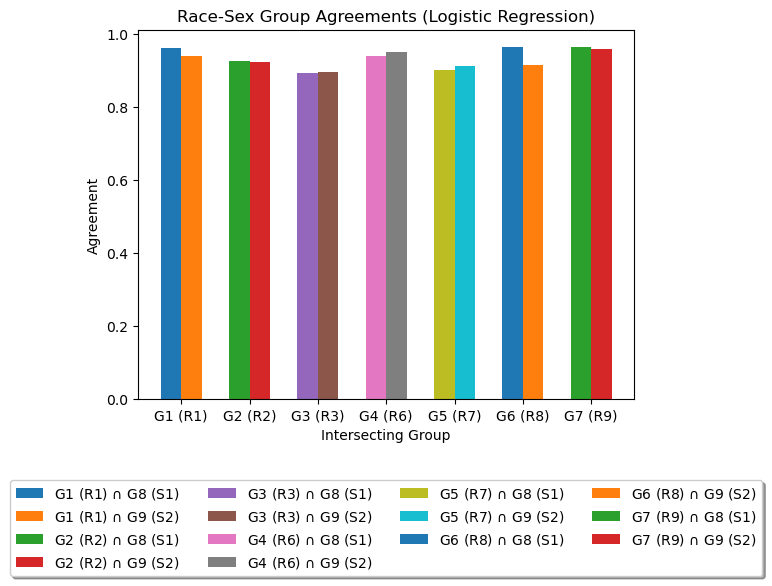

In [27]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

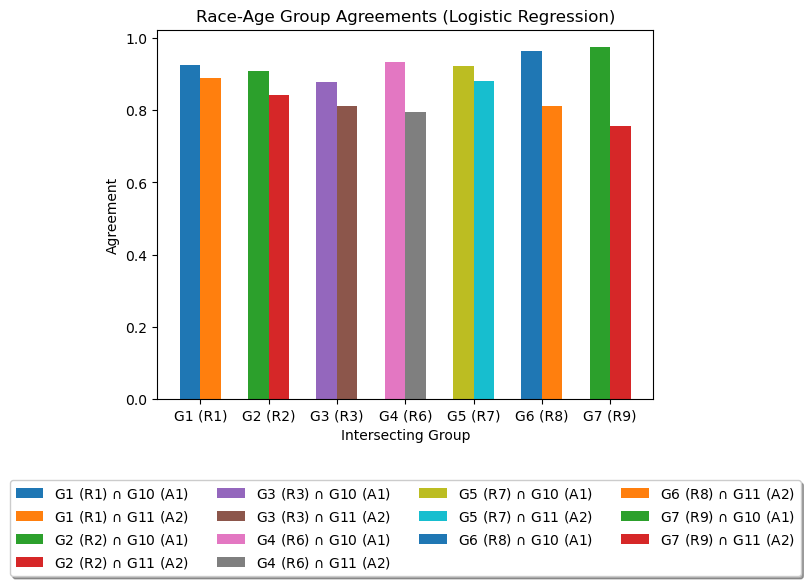

In [28]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

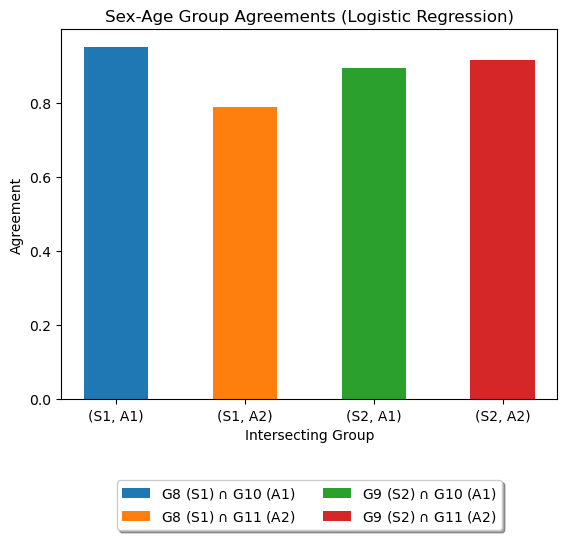

In [30]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, lr_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, lr_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, lr_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, lr_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

## Take a look at the A2 classifier

In [33]:
# test errors again
lr_test_err = {}
for g in range(num_groups):
    lr_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,lr_test_err[g], std_err(lr_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.20919595250442113 (+/-0.002097475737468698; n=75207)
group 1 (R1): 0.20552830066348252 (+/-0.002656657612160973; n=46271)
group 2 (R2): 0.21088794926004228 (+/-0.009378527443975845; n=3784)
group 3 (R3): 0.25338491295938104 (+/-0.02705256712731249; n=517)
group 4 (R6): 0.23326039387308534 (+/-0.00559540265373844; n=11425)
group 5 (R7): 0.2357142857142857 (+/-0.03587210030336845; n=280)
group 6 (R8): 0.20705805467813965 (+/-0.005980489949053107; n=9181)
group 7 (R9): 0.1656372824256036 (+/-0.008808957881882231; n=3562)
group 8 (S1): 0.17441388821286608 (+/-0.0027905987394349916; n=36981)
group 9 (S2): 0.2378485847329043 (+/-0.0030796863356841882; n=38226)
group 10 (A1): 0.20437622262888874 (+/-0.002265064294255182; n=63388)
group 11 (A2): 0.15009730095608764 (+/-0.004646176214296712; n=11819)


In [53]:
print("P(Y = 1 | G11) =\t{}".format(np.mean(y_test[group_test[11]])))
print("P(h11 = 1 | G11) =\t{}".format(np.mean(yhats[11][group_test[11]])))

P(Y = 1 | G11) =	0.15035112953718588
P(h11 = 1 | G11) =	0.0034689906083424996


# Decision Trees

In [54]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
LOAD_DATA = True
SAVE_DATA_PATH = 'employment_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

dt_test_err = {}
for g in range(num_groups):
    dt_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,dt_test_err[g], std_err(dt_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.18564761258925366 (+/-0.0020051032299047192; n=75207)
group 1 (R1): 0.18620734369259365 (+/-0.002559268437454397; n=46271)
group 2 (R2): 0.18181818181818182 (+/-0.008867128483123024; n=3784)
group 3 (R3): 0.23017408123791103 (+/-0.026181480421782644; n=517)
group 4 (R6): 0.19045951859956237 (+/-0.005195262787057864; n=11425)
group 5 (R7): 0.21785714285714286 (+/-0.034887104470119584; n=280)
group 6 (R8): 0.1813527938133101 (+/-0.005686964554153246; n=9181)
group 7 (R9): 0.16058394160583941 (+/-0.00869976925043214; n=3562)
group 8 (S1): 0.15253778967577947 (+/-0.0026440798573251242; n=36981)
group 9 (S2): 0.21754826557840212 (+/-0.002984297818671847; n=38226)
group 10 (A1): 0.19164510632927367 (+/-0.0022108606812777203; n=63388)
group 11 (A2): 0.1501819104831204 (+/-0.004647254210559716; n=11819)


In [60]:
# Get group-conditional agreements for Race-Sex pairs
dt_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    dt_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.9698726892221835
R1 and S2 agreement on (R1, S2):	0.9604028283694022
R2 and S1 agreement on (R2, S1):	0.9408315565031983
R2 and S2 agreement on (R2, S2):	0.960691823899371
R3 and S1 agreement on (R3, S1):	0.8605577689243028
R3 and S2 agreement on (R3, S2):	0.8195488721804511
R6 and S1 agreement on (R6, S1):	0.959401309635173
R6 and S2 agreement on (R6, S2):	0.8774671052631579
R7 and S1 agreement on (R7, S1):	0.849624060150376
R7 and S2 agreement on (R7, S2):	0.8979591836734694
R8 and S1 agreement on (R8, S1):	0.987001733102253
R8 and S2 agreement on (R8, S2):	0.8963855421686747
R9 and S1 agreement on (R9, S1):	0.9501449275362319
R9 and S2 agreement on (R9, S2):	0.9412084921066957


In [64]:
# Get group-conditional agreements for Race-Age pairs
dt_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    dt_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1, A1):	0.9586405131344317
R1 and A2 agreement on (R1, A2):	0.9730972637387906
R2 and A1 agreement on (R2, A1):	0.9474342928660826
R2 and A2 agreement on (R2, A2):	0.9591836734693877
R3 and A1 agreement on (R3, A1):	0.8146551724137931
R3 and A2 agreement on (R3, A2):	1.0
R6 and A1 agreement on (R6, A1):	0.911520737327189
R6 and A2 agreement on (R6, A2):	0.9704819277108434
R7 and A1 agreement on (R7, A1):	0.8666666666666667
R7 and A2 agreement on (R7, A2):	0.92
R8 and A1 agreement on (R8, A1):	0.9287119546348802
R8 and A2 agreement on (R8, A2):	0.987037037037037
R9 and A1 agreement on (R9, A1):	0.9531953195319532
R9 and A2 agreement on (R9, A2):	0.9344978165938864


In [65]:
# Get group-conditional agreements for Sex-Age pairs
dt_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    dt_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1, A1):	0.9900727994705493
S1 and A2 agreement on (S1, A2):	0.9834285714285714
S2 and A1 agreement on (S2, A1):	0.9486369523328174
S2 and A2 agreement on (S2, A2):	0.9862992845181915


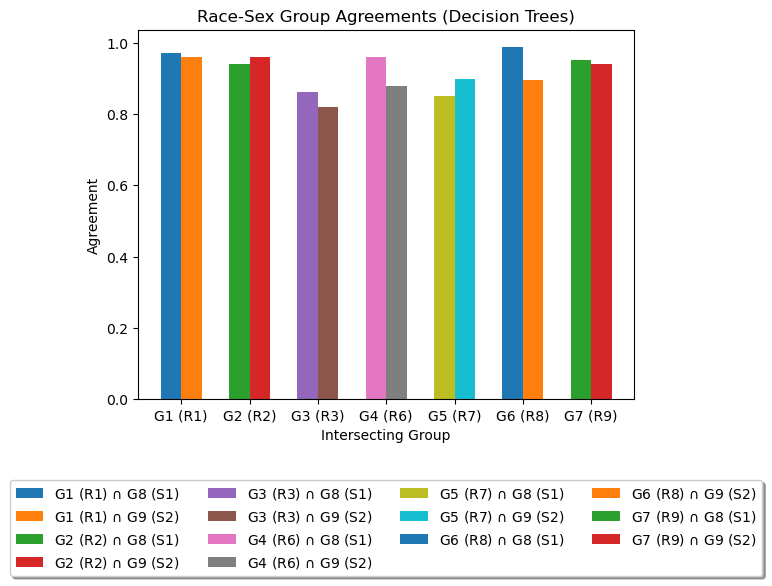

In [66]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

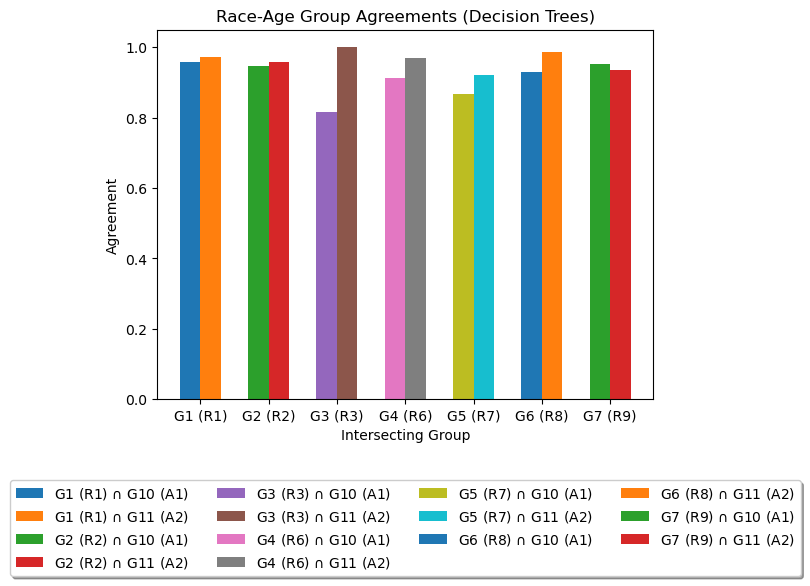

In [67]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

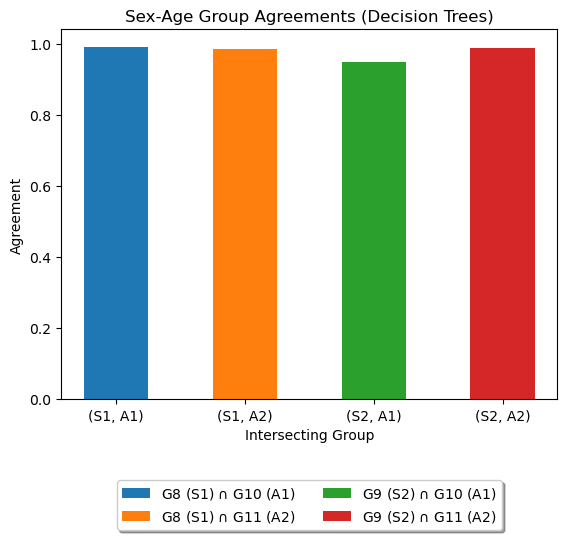

In [69]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, dt_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, dt_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, dt_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, dt_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Decision Trees)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# Gradient-Boosted Trees

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

In [72]:
LOAD_DATA = True
SAVE_DATA_PATH = 'employment_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.18003643277886366 (+/-0.0019813597804882897; n=75207)
group 1 (R1): 0.1822091590845238 (+/-0.0025378548422241016; n=46271)
group 2 (R2): 0.18208245243128965 (+/-0.00887213709140339; n=3784)
group 3 (R3): 0.218568665377176 (+/-0.025704495681297648; n=517)
group 4 (R6): 0.1848577680525164 (+/-0.005135969584208841; n=11425)
group 5 (R7): 0.20357142857142857 (+/-0.03403045925982197; n=280)
group 6 (R8): 0.1798279054569219 (+/-0.005668276687765146; n=9181)
group 7 (R9): 0.14991577765300393 (+/-0.008459071368246161; n=3562)
group 8 (S1): 0.14929288012763312 (+/-0.0026208082940699165; n=36981)
group 9 (S2): 0.20977868466488778 (+/-0.002945036075991285; n=38226)
group 10 (A1): 0.18620243579226353 (+/-0.0021865647624193614; n=63388)
group 11 (A2): 0.14823589136136728 (+/-0.004622330387766275; n=11819)


In [73]:
# Get group-conditional agreements for Race-Sex pairs
gb_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    gb_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.9862225322636903
R1 and S2 agreement on (R1, S2):	0.9770302121277051
R2 and S1 agreement on (R2, S1):	0.9504264392324094
R2 and S2 agreement on (R2, S2):	0.950733752620545
R3 and S1 agreement on (R3, S1):	0.9243027888446215
R3 and S2 agreement on (R3, S2):	0.8533834586466166
R6 and S1 agreement on (R6, S1):	0.9663236669784846
R6 and S2 agreement on (R6, S2):	0.9516447368421053
R7 and S1 agreement on (R7, S1):	0.9172932330827067
R7 and S2 agreement on (R7, S2):	0.9115646258503401
R8 and S1 agreement on (R8, S1):	0.9781195840554593
R8 and S2 agreement on (R8, S2):	0.935815991237678
R9 and S1 agreement on (R9, S1):	0.9739130434782609
R9 and S2 agreement on (R9, S2):	0.9667936853565596


In [74]:
# Get group-conditional agreements for Race-Sex pairs
gb_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    gb_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1, A1):	0.980358235967317
R1 and A2 agreement on (R1, A2):	0.9850540354104392
R2 and A1 agreement on (R2, A1):	0.9515018773466833
R2 and A2 agreement on (R2, A2):	0.9914965986394558
R3 and A1 agreement on (R3, A1):	0.9116379310344828
R3 and A2 agreement on (R3, A2):	1.0
R6 and A1 agreement on (R6, A1):	0.958115719406042
R6 and A2 agreement on (R6, A2):	0.9795180722891567
R7 and A1 agreement on (R7, A1):	0.9058823529411765
R7 and A2 agreement on (R7, A2):	1.0
R8 and A1 agreement on (R8, A1):	0.9600740655016781
R8 and A2 agreement on (R8, A2):	0.9925925925925926
R9 and A1 agreement on (R9, A1):	0.9714971497149715
R9 and A2 agreement on (R9, A2):	0.982532751091703


In [75]:
# Get group-conditional agreements for Sex-Age pairs
gb_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    gb_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1, A1):	0.9842110239198261
S1 and A2 agreement on (S1, A2):	0.9841904761904762
S2 and A1 agreement on (S2, A1):	0.9705594339324636
S2 and A2 agreement on (S2, A2):	0.9898005784746536


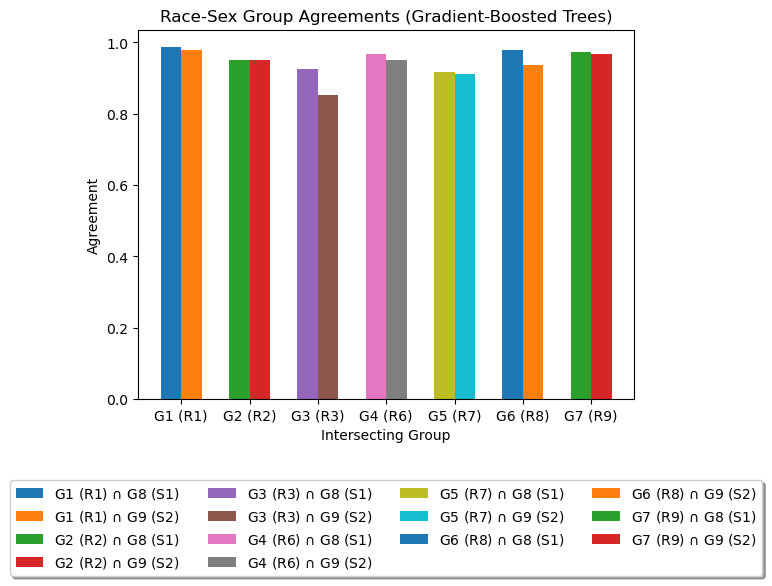

In [76]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

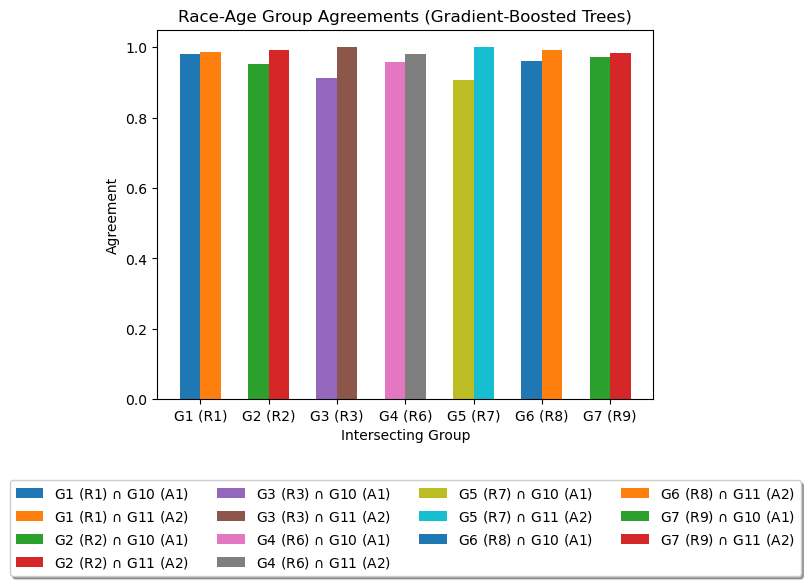

In [77]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

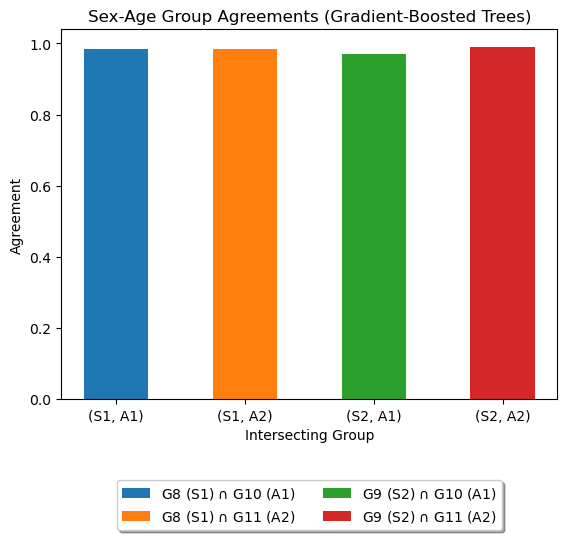

In [78]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, gb_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, gb_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, gb_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, gb_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# XGBoost

In [79]:
from xgboost import XGBClassifier

In [80]:
LOAD_DATA = True
SAVE_DATA_PATH = 'employment_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.17975720345180635 (+/-0.001980159753687931; n=75207)
group 1 (R1): 0.1811285686499103 (+/-0.002531989454548439; n=46271)
group 2 (R2): 0.17653276955602537 (+/-0.008765471095428416; n=3784)
group 3 (R3): 0.24758220502901354 (+/-0.026844725575543658; n=517)
group 4 (R6): 0.18669584245076587 (+/-0.005155617782988295; n=11425)
group 5 (R7): 0.21785714285714286 (+/-0.034887104470119584; n=280)
group 6 (R8): 0.1783030171005337 (+/-0.005649437342994943; n=9181)
group 7 (R9): 0.15384615384615385 (+/-0.008549407707349696; n=3562)
group 8 (S1): 0.14972553473405262 (+/-0.002623935633332468; n=36981)
group 9 (S2): 0.21048501020247998 (+/-0.002948671189579974; n=38226)
group 10 (A1): 0.18604467722597337 (+/-0.0021858501291164294; n=63388)
group 11 (A2): 0.14815128183433454 (+/-0.004621240548377646; n=11819)


In [81]:
# Get group-conditional agreements for Race-Sex pairs
xgb_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    xgb_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.9875305197070108
R1 and S2 agreement on (R1, S2):	0.977158774373259
R2 and S1 agreement on (R2, S1):	0.9712153518123667
R2 and S2 agreement on (R2, S2):	0.9643605870020965
R3 and S1 agreement on (R3, S1):	0.9282868525896414
R3 and S2 agreement on (R3, S2):	0.868421052631579
R6 and S1 agreement on (R6, S1):	0.9739943872778297
R6 and S2 agreement on (R6, S2):	0.9595394736842106
R7 and S1 agreement on (R7, S1):	0.9323308270676691
R7 and S2 agreement on (R7, S2):	0.9047619047619048
R8 and S1 agreement on (R8, S1):	0.9859185441941074
R8 and S2 agreement on (R8, S2):	0.9590361445783132
R9 and S1 agreement on (R9, S1):	0.9744927536231884
R9 and S2 agreement on (R9, S2):	0.9640718562874252


In [82]:
# Get group-conditional agreements for Race-Age pairs
xgb_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    xgb_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1, A1):	0.9819551273520879
R1 and A2 agreement on (R1, A2):	0.9929868935387446
R2 and A1 agreement on (R2, A1):	0.9702753441802253
R2 and A2 agreement on (R2, A2):	0.9897959183673469
R3 and A1 agreement on (R3, A1):	0.8814655172413793
R3 and A2 agreement on (R3, A2):	1.0
R6 and A1 agreement on (R6, A1):	0.9645673323092678
R6 and A2 agreement on (R6, A2):	0.9789156626506024
R7 and A1 agreement on (R7, A1):	0.9137254901960784
R7 and A2 agreement on (R7, A2):	1.0
R8 and A1 agreement on (R8, A1):	0.9753500752227752
R8 and A2 agreement on (R8, A2):	0.9944444444444445
R9 and A1 agreement on (R9, A1):	0.9717971797179717
R9 and A2 agreement on (R9, A2):	0.9912663755458515


In [83]:
# Get group-conditional agreements for Race-Age pairs
xgb_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    xgb_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1, A1):	0.9886546279663421
S1 and A2 agreement on (S1, A2):	0.9927619047619047
S2 and A1 agreement on (S2, A1):	0.973497172821177
S2 and A2 agreement on (S2, A2):	0.9945197138072766


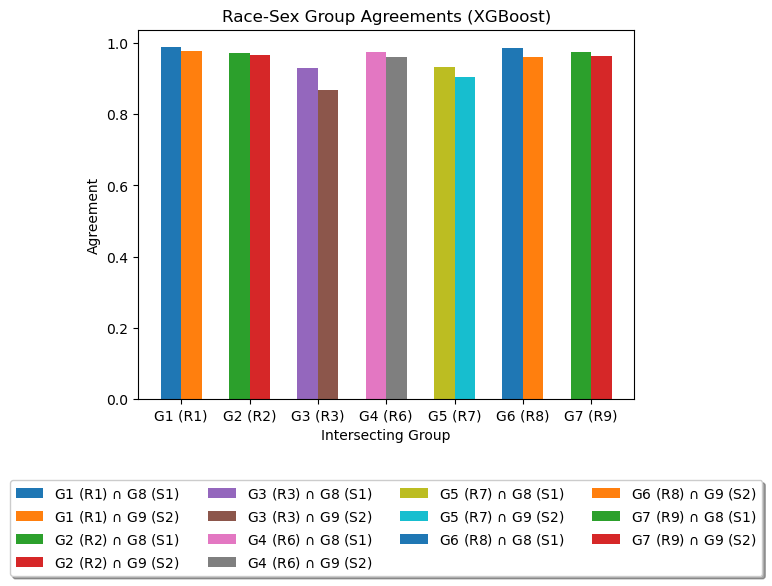

In [84]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

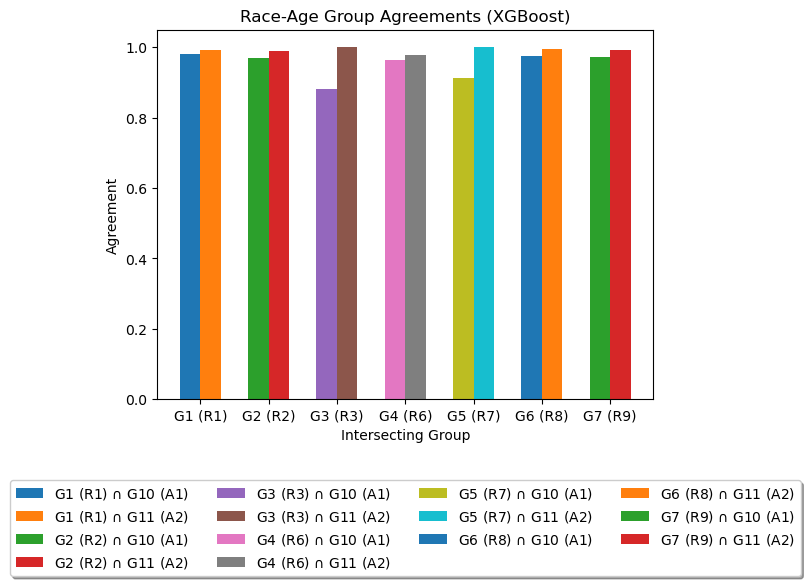

In [85]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

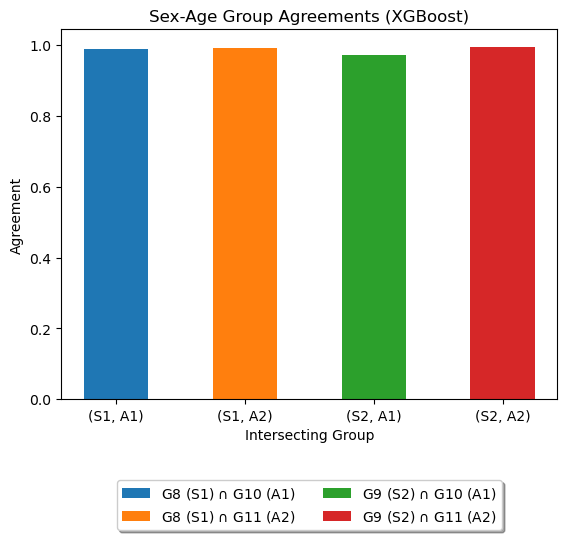

In [86]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, xgb_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, xgb_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, xgb_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, xgb_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (XGBoost)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# AdaBoost

In [87]:
from sklearn.ensemble import AdaBoostClassifier

In [88]:
LOAD_DATA = True
SAVE_DATA_PATH = 'employment_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.1879080404749558 (+/-0.002014471615586927; n=75207)
group 1 (R1): 0.18800112381405198 (+/-0.0025687302011679126; n=46271)
group 2 (R2): 0.18234672304439747 (+/-0.0088771387155752; n=3784)
group 3 (R3): 0.24177949709864605 (+/-0.026630371390428526; n=517)
group 4 (R6): 0.194835886214442 (+/-0.005240389576736578; n=11425)
group 5 (R7): 0.225 (+/-0.03529214805428701; n=280)
group 6 (R8): 0.18832371201394182 (+/-0.005770506525692614; n=9181)
group 7 (R9): 0.1527231892195396 (+/-0.008523798855946686; n=3562)
group 8 (S1): 0.15480922635948188 (+/-0.0026601214576220055; n=36981)
group 9 (S2): 0.21456600219745722 (+/-0.0029694148275131176; n=38226)
group 10 (A1): 0.19522622578406007 (+/-0.0022264731389970067; n=63388)
group 11 (A2): 0.14823589136136728 (+/-0.004622330387766275; n=11819)


In [96]:
# Get group-conditional agreements for Race-Sex pairs
ada_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    ada_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.973622253226369
R1 and S2 agreement on (R1, S2):	0.9448467966573816
R2 and S1 agreement on (R2, S1):	0.9328358208955224
R2 and S2 agreement on (R2, S2):	0.9575471698113207
R3 and S1 agreement on (R3, S1):	0.9442231075697212
R3 and S2 agreement on (R3, S2):	0.9360902255639098
R6 and S1 agreement on (R6, S1):	0.9543498596819457
R6 and S2 agreement on (R6, S2):	0.930921052631579
R7 and S1 agreement on (R7, S1):	0.924812030075188
R7 and S2 agreement on (R7, S2):	0.9251700680272109
R8 and S1 agreement on (R8, S1):	0.9776863084922011
R8 and S2 agreement on (R8, S2):	0.8898138006571742
R9 and S1 agreement on (R9, S1):	0.9663768115942029
R9 and S2 agreement on (R9, S2):	0.9635274904735982


In [97]:
# Get group-conditional agreements for Race-Age pairs
ada_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    ada_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1, A1):	0.9655071460889468
R1 and A2 agreement on (R1, A2):	0.9825247183260519
R2 and A1 agreement on (R2, A1):	0.935857321652065
R2 and A2 agreement on (R2, A2):	0.9727891156462585
R3 and A1 agreement on (R3, A1):	0.9094827586206896
R3 and A2 agreement on (R3, A2):	1.0
R6 and A1 agreement on (R6, A1):	0.9503328213005633
R6 and A2 agreement on (R6, A2):	0.9746987951807229
R7 and A1 agreement on (R7, A1):	0.9333333333333333
R7 and A2 agreement on (R7, A2):	1.0
R8 and A1 agreement on (R8, A1):	0.9693322532114339
R8 and A2 agreement on (R8, A2):	0.9777777777777777
R9 and A1 agreement on (R9, A1):	0.9651965196519652
R9 and A2 agreement on (R9, A2):	0.9781659388646288


In [98]:
# Get group-conditional agreements for Sex-Age pairs
ada_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    ada_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1, A1):	0.9733068607985881
S1 and A2 agreement on (S1, A2):	0.9805714285714285
S2 and A1 agreement on (S2, A1):	0.9397289698960736
S2 and A2 agreement on (S2, A2):	0.9931496422590957


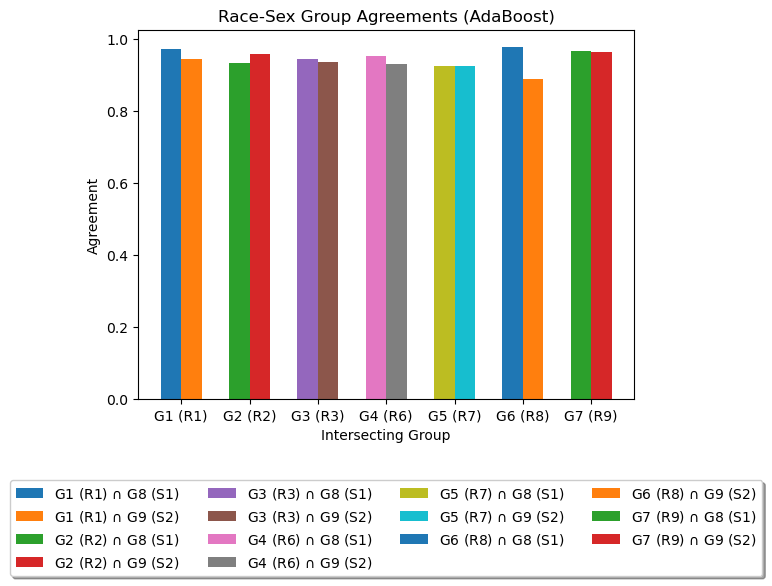

In [99]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, ada_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, ada_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

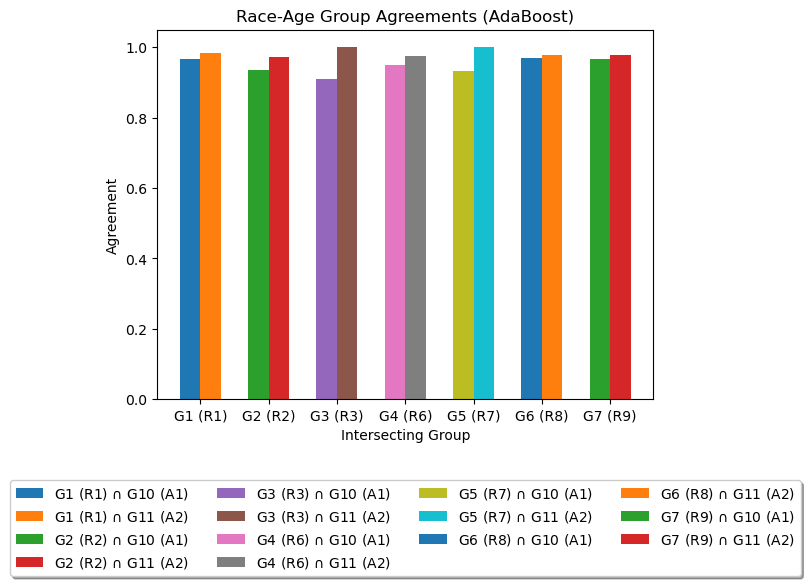

In [100]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, ada_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, ada_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

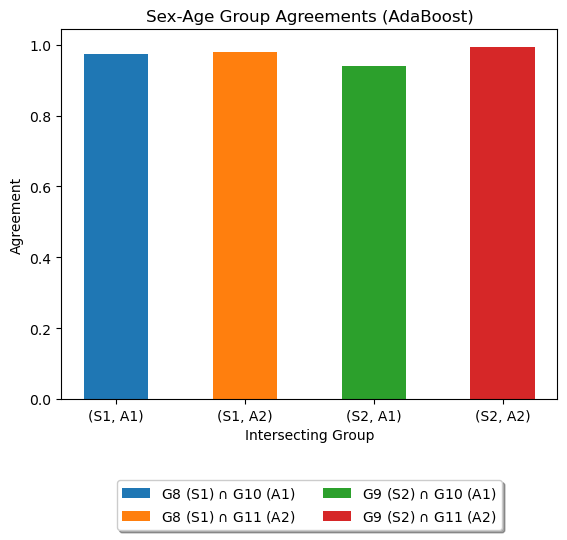

In [101]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, ada_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, ada_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, ada_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, ada_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (AdaBoost)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# All Together

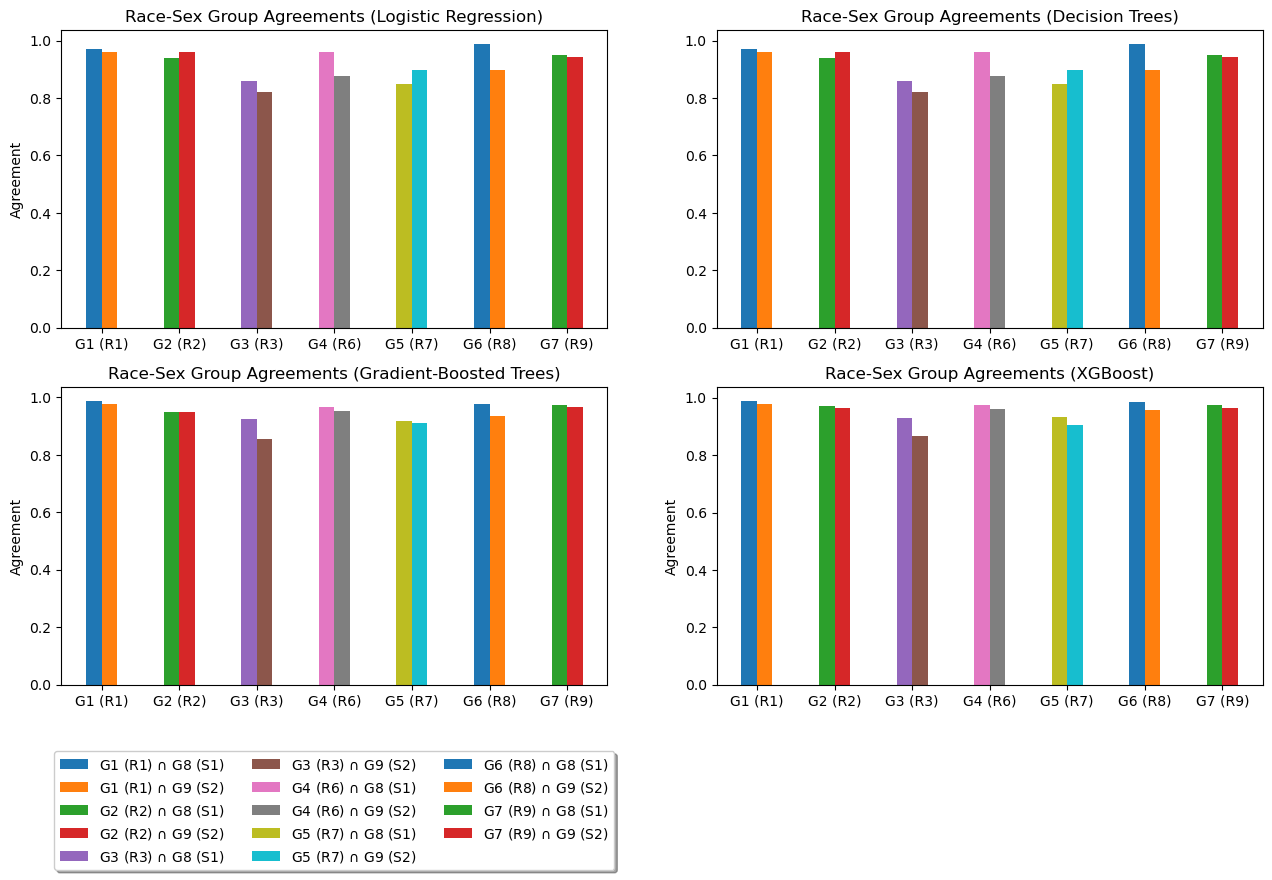

In [116]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15.5, 8.5)
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.2

# LOGISTIC REGRESSION
for i in range(num_bars):
    if i % 2 == 0:
        ax[0][0].bar(int(i/2) - bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax[0][0].bar(int(i/2) + bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax[0][0].set_ylabel('Agreement')
ax[0][0].set_title('Race-Sex Group Agreements (Logistic Regression)')
ax[0][0].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# DECISON TREES
for i in range(num_bars):
    if i % 2 == 0:
        ax[0][1].bar(int(i/2) - bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax[0][1].bar(int(i/2) + bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax[0][1].set_title('Race-Sex Group Agreements (Decision Trees)')
ax[0][1].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# GRADIENT-BOOSTED TREES
for i in range(num_bars):
    if i % 2 == 0:
        ax[1][0].bar(int(i/2) - bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax[1][0].bar(int(i/2) + bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax[1][0].set_ylabel('Agreement')
ax[1][0].set_title('Race-Sex Group Agreements (Gradient-Boosted Trees)')
ax[1][0].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# XGBOOST
for i in range(num_bars):
    if i % 2 == 0:
        ax[1][1].bar(int(i/2) - bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax[1][1].bar(int(i/2) + bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax[1][1].set_ylabel('Agreement')
ax[1][1].set_title('Race-Sex Group Agreements (XGBoost)')
ax[1][1].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

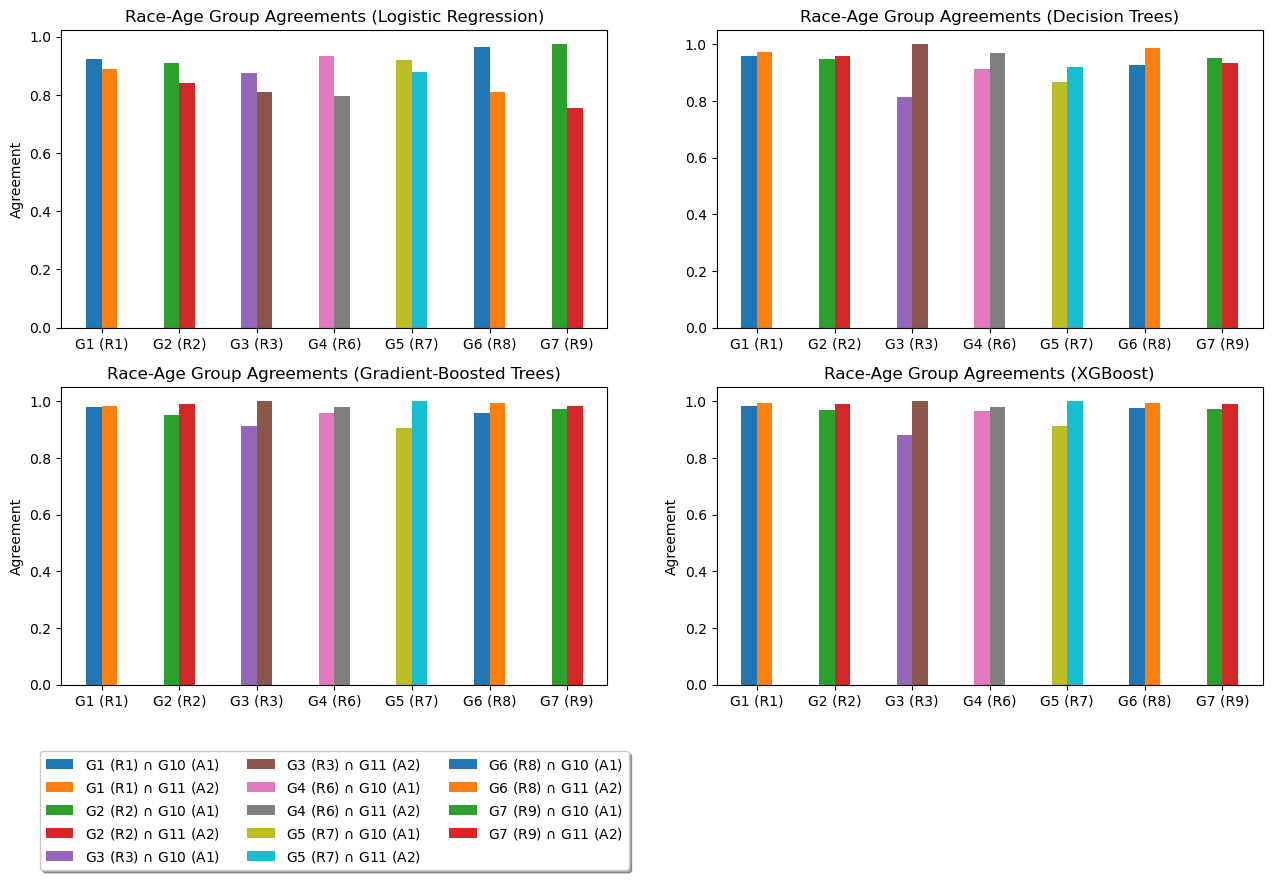

In [117]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15.5, 8.5)
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.2

# LOGISTIC REGRESSION
for i in range(num_bars):
    if i % 2 == 0:
        ax[0][0].bar(int(i/2) - bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax[0][0].bar(int(i/2) + bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax[0][0].set_ylabel('Agreement')
ax[0][0].set_title('Race-Age Group Agreements (Logistic Regression)')
ax[0][0].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# DECISON TREES
for i in range(num_bars):
    if i % 2 == 0:
        ax[0][1].bar(int(i/2) - bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax[0][1].bar(int(i/2) + bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax[0][1].set_title('Race-Age Group Agreements (Decision Trees)')
ax[0][1].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# GRADIENT-BOOSTED TREES
for i in range(num_bars):
    if i % 2 == 0:
        ax[1][0].bar(int(i/2) - bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax[1][0].bar(int(i/2) + bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax[1][0].set_ylabel('Agreement')
ax[1][0].set_title('Race-Age Group Agreements (Gradient-Boosted Trees)')
ax[1][0].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# XGBOOST
for i in range(num_bars):
    if i % 2 == 0:
        ax[1][1].bar(int(i/2) - bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax[1][1].bar(int(i/2) + bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax[1][1].set_ylabel('Agreement')
ax[1][1].set_title('Race-Age Group Agreements (XGBoost)')
ax[1][1].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

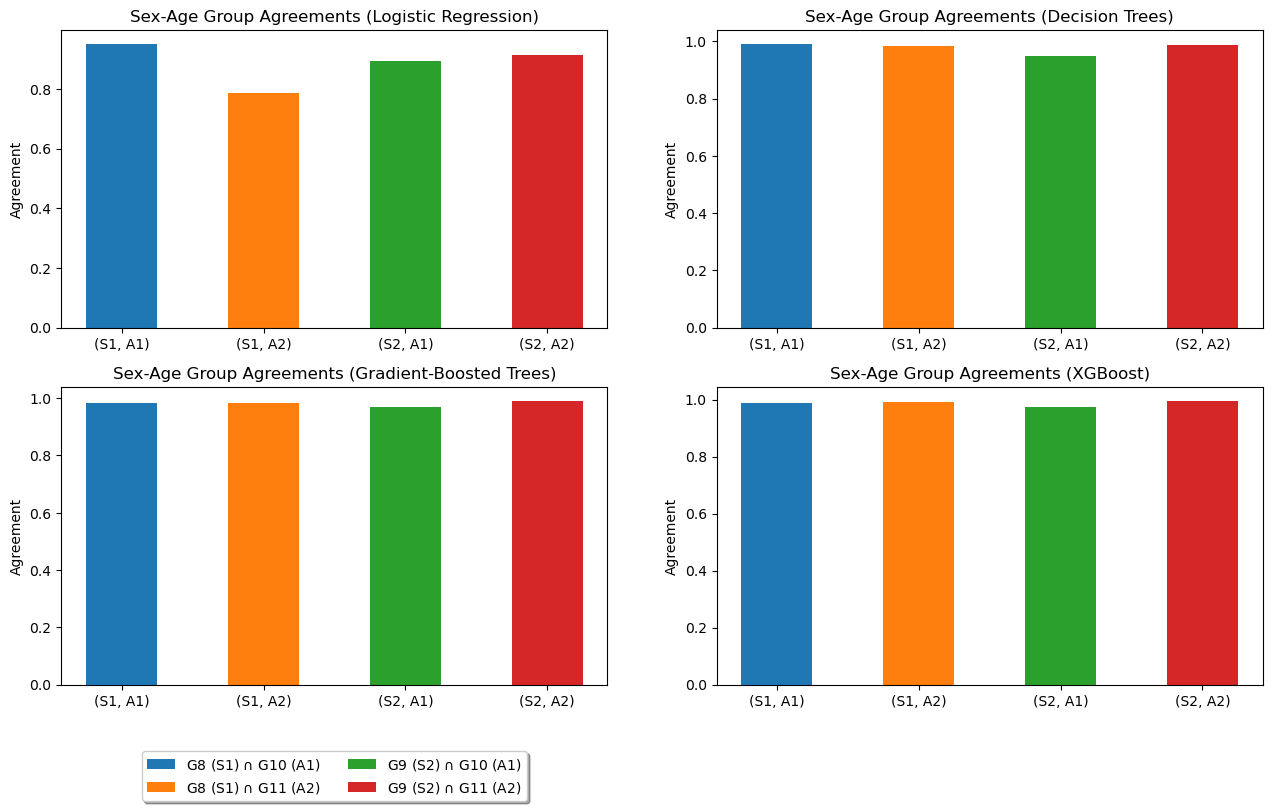

In [125]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15.5, 8.5)
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

# LOGISTIC REGRESSION
for i in range(num_bars):
    ax[0][0].bar(i, lr_sex_age_agreements[i], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[i][0], group_names[sex_age_pairs[i][0]],
                                                         sex_age_pairs[i][1], group_names[sex_age_pairs[i][1]]))
ax[0][0].set_ylabel('Agreement')
ax[0][0].set_title('Sex-Age Group Agreements (Logistic Regression)')
ax[0][0].set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))

# DECISON TREES
for i in range(num_bars):
    ax[0][1].bar(i, dt_sex_age_agreements[i], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[i][0], group_names[sex_age_pairs[i][0]],
                                                         sex_age_pairs[i][1], group_names[sex_age_pairs[i][1]]))
ax[0][1].set_ylabel('Agreement')
ax[0][1].set_title('Sex-Age Group Agreements (Decision Trees)')
ax[0][1].set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))

# GRADIENT-BOOSTED TREES
for i in range(num_bars):
    ax[1][0].bar(i, gb_sex_age_agreements[i], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[i][0], group_names[sex_age_pairs[i][0]],
                                                         sex_age_pairs[i][1], group_names[sex_age_pairs[i][1]]))
ax[1][0].set_ylabel('Agreement')
ax[1][0].set_title('Sex-Age Group Agreements (Gradient-Boosted Trees)')
ax[1][0].set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))

# XGBOOST
for i in range(num_bars):
    ax[1][1].bar(i, xgb_sex_age_agreements[i], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[i][0], group_names[sex_age_pairs[i][0]],
                                                         sex_age_pairs[i][1], group_names[sex_age_pairs[i][1]]))
ax[1][1].set_ylabel('Agreement')
ax[1][1].set_title('Sex-Age Group Agreements (XGBoost)')
ax[1][1].set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
plt.show()